In [1]:
import numpy as np
import matplotlib.pyplot as plt


In [2]:
def f_true(x):
    return 0.03 * x ** 4 - 0.4 * x ** 2 + 0.7 * np.sin(2.2 * x)

def make_poly_features(x, degree):
    x = np.asarray(x).reshape(-1, 1)
    X = np.hstack([x ** i for i in range(degree + 1)])
    return X

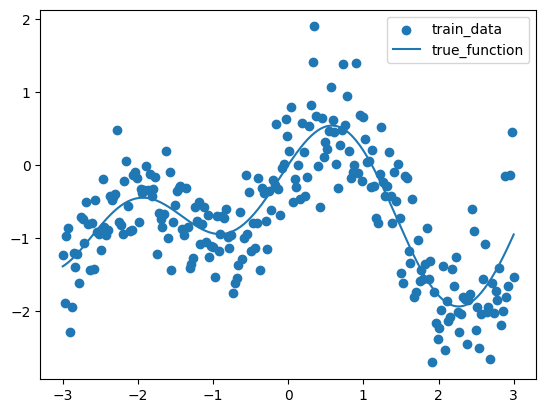

In [3]:
rng = np.random.default_rng(42)

N = 250
x = np.linspace(-3, 3, N)

sigma = 0.5
y = f_true(x) + rng.normal(0, sigma, size=x.shape)

degree = 15
X = make_poly_features(x, degree)

plt.scatter(x, y, label='train_data')
plt.plot(x, f_true(x), label='true_function')
plt.legend()
plt.show()

In [4]:
lamb = 1.0
alpha = 1.0 / (sigma ** 2)

M = X.shape[1]
posterior_cov_inv = lamb * np.eye(M) + alpha * (X.T @ X)

In [5]:
posterior_cov = np.linalg.inv(posterior_cov_inv)
mean = alpha * posterior_cov @ (X.T @ y)

In [6]:
x_new = np.linspace(-3, 3, 400)
X_new = make_poly_features(x_new, degree)

mean_pred = X_new @ mean
var_pred = 1.0 / alpha + np.sum(X_new @ posterior_cov @ X_new.T, axis=1)
std_pred = np.sqrt(var_pred)

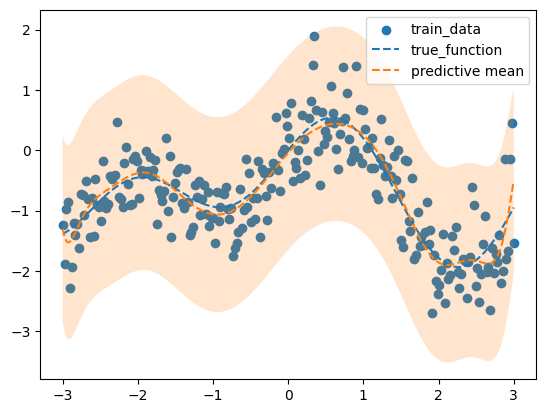

In [7]:
plt.scatter(x, y, label='train_data')
plt.plot(x_new, f_true(x_new), linestyle='--', label='true_function')
plt.plot(x_new, mean_pred, linestyle='--', label='predictive mean')

plt.fill_between(x_new, mean_pred - 2 * std_pred, mean_pred + 2 * std_pred, alpha=0.2)

plt.legend()
plt.show()

In [8]:
def log_evidence(lamb, X, y, alpha):
    n = X.shape[0]
    M = X.shape[1]
    
    posterior_cov_inv = lamb * np.eye(M) + alpha * (X.T @ X)
    posterior_cov = np.linalg.inv(posterior_cov_inv)
    mean = alpha * posterior_cov @ (X.T @ y)
    
    log_ev = (M / 2) * np.log(lamb) + (n / 2) * np.log(alpha) - (n / 2) * np.log(2 * np.pi)
    log_ev -= 0.5 * np.log(np.linalg.det(posterior_cov_inv))
    log_ev -= 0.5 * (alpha * np.sum((y - X @ mean) ** 2) + lamb * np.sum(mean ** 2))
    
    return log_ev

In [9]:
lambdas = np.logspace(-6, 3, 160)
log_evidences = [log_evidence(lamb, X, y, alpha) for lamb in lambdas]

best_idx = np.argmax(log_evidences)
best_lambda = lambdas[best_idx]

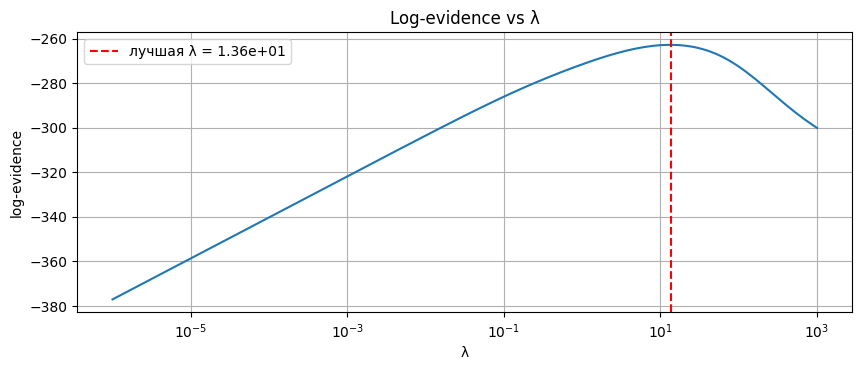

In [10]:
plt.figure(figsize=(10, 8))

plt.subplot(2, 1, 1)
plt.semilogx(lambdas, log_evidences)
plt.axvline(best_lambda, color='red', linestyle='--', label=f'лучшая λ = {best_lambda:.2e}')
plt.xlabel('λ')
plt.ylabel('log-evidence')
plt.title('Log-evidence vs λ')
plt.legend()
plt.grid(True)

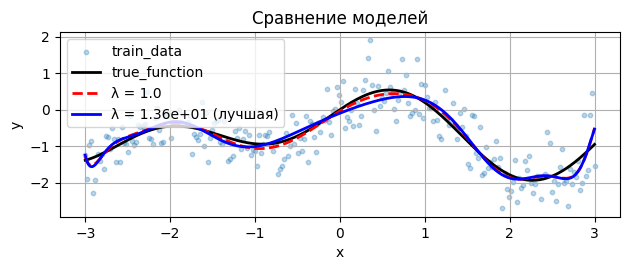

In [11]:
x_new = np.linspace(-3, 3, 400)
X_new = make_poly_features(x_new, degree)

lamb_original = 1.0
posterior_cov_inv_orig = lamb_original * np.eye(X.shape[1]) + alpha * (X.T @ X)
posterior_cov_orig = np.linalg.inv(posterior_cov_inv_orig)
mean_orig = alpha * posterior_cov_orig @ (X.T @ y)
mean_pred_orig = X_new @ mean_orig

posterior_cov_inv_best = best_lambda * np.eye(X.shape[1]) + alpha * (X.T @ X)
posterior_cov_best = np.linalg.inv(posterior_cov_inv_best)
mean_best = alpha * posterior_cov_best @ (X.T @ y)
mean_pred_best = X_new @ mean_best

plt.subplot(2, 1, 2)
plt.scatter(x, y, alpha=0.3, label='train_data', s=10)
plt.plot(x_new, f_true(x_new), 'k-', label='true_function', linewidth=2)
plt.plot(x_new, mean_pred_orig, 'r--', label=f'λ = {lamb_original}', linewidth=2)
plt.plot(x_new, mean_pred_best, 'b-', label=f'λ = {best_lambda:.2e} (лучшая)', linewidth=2)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Сравнение моделей')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## Выводы
#### Исходная λ = 1.0 была слишком большой
#### Модель с оптимальной λ дает более плавную аппроксимаци
#### Evidence procedure успешно предотвратила переобучение